In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
PACKAGE_ROOT = os.path.dirname(os.path.abspath(""))
# print(PACKAGE_ROOT)
sys.path.insert(0, PACKAGE_ROOT)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, TimeDistributed, Dense, Dropout
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
plt.style.use("ggplot")

from commons import constants as C
from utils.utils import get_connl_data
from utils.utils import SentenceGetter
from preprocessing.lstm_crf_preprocessor import LSTMCRFPreprocessor
from data.ingestor import DataSaver

In [2]:
train_df = get_connl_data("train")
valid_df = get_connl_data("valid")
test_df = get_connl_data("test")

train_sentences = SentenceGetter(train_df).sentences
valid_sentences = SentenceGetter(valid_df).sentences
test_sentences = SentenceGetter(test_df).sentences

In [3]:
obj = LSTMCRFPreprocessor()
train_sentences = obj.get_sentences(train_df)

words = obj.get_words(train_df)
n_words = len(words)
print(f"Number of words: {n_words}")
tags = obj.get_tags(train_df)
n_tags = len(tags)
print(f"Number of tags: {n_tags}")
max_length = obj.get_max_length(train_sentences)
print(f"Maximum length of sentence: {max_length}")

Number of words: 29574
Number of tags: 67
Maximum length of sentence: 52


In [4]:
word2idx, idx2word, tag2idx, idx2tag = obj.get_indices(words, tags)
X_train, y_train = obj.preprocess(
    train_sentences, word2idx, tag2idx, max_length, n_tags, n_words
)

y_train = np.array(y_train)
X_valid, y_valid = obj.preprocess(
    valid_sentences, word2idx, tag2idx, max_length, n_tags, n_words
)
y_valid = np.array(y_valid)

X_test, y_test = obj.preprocess(
    test_sentences, word2idx, tag2idx, max_length, n_tags, n_words
)
y_test = np.array(y_test)

In [5]:
# input = Input(shape=(max_len,))
# model = Embedding(input_dim=n_words + 1, output_dim=20,
#                   input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
# model = Bidirectional(LSTM(units=50, return_sequences=True,
#                            recurrent_dropout=0.1))(model)  # variational biLSTM
# model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
# crf = CRF(n_tags)  # CRF layer
# out = crf(model)  # output

# model = Model(input, out)
# model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [6]:
from tf2crf import CRF, ModelWithCRFLoss
input = Input(shape=(max_length,), dtype=np.int32)
model = Embedding(input_dim=n_words, output_dim=20,
                  input_length=max_length, mask_zero=True)(input)
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(units=n_tags)
output = crf(model)
base_model = Model(input, output)
model = ModelWithCRFLoss(base_model, sparse_target=True)
model.compile(optimizer="adam", loss=crf.accuracy_fn)
# model.build(input_shape=(max_length,))
# model.summary()
# model = Model(input, out)
# model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
from datetime import datetime, timedelta
model_type = "lstmcrf"
now = datetime.utcnow() + timedelta(hours=5, minutes=30)
FOLDER_NAME = f"{model_type}-model-"+now.strftime("%d-%m-%Y-%H-%M-%S")
FOLDER_PATH = os.path.join(C.MODELS_OUTPUT_DIR, FOLDER_NAME)
print(FOLDER_PATH)
if not os.path.exists(FOLDER_PATH):
    os.makedirs(FOLDER_PATH)
checkpoint_filepath = os.path.join(FOLDER_PATH, "checkpoint")
# FILE_PATH = os.path.join(C.MODELS_OUTPUT_DIR, FILE_NAME)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_val_accuracy',
    mode='max',
    save_best_only=True)

C:\Users\sharm\Documents\workspace\gitworks\ner-bilstm-crf\outputs\model_artifacts\lstmcrf-model-26-03-2023-01-12-32


In [8]:
history = model.fit(
    x=X_train, 
    y=y_train, 
    epochs=50, 
    batch_size=256, 
    validation_data=(X_valid, y_valid), 
    verbose=2, 
    callbacks=[model_checkpoint_callback]
) # type: ignore

Epoch 1/50
57/57 - 40s - loss: 99.4154 - accuracy: 0.7028 - val_loss_val: 24.8208 - val_val_accuracy: 0.9404 - 40s/epoch - 696ms/step
Epoch 2/50
57/57 - 31s - loss: 21.7769 - accuracy: 0.9398 - val_loss_val: 19.9410 - val_val_accuracy: 0.9404 - 31s/epoch - 547ms/step
Epoch 3/50
57/57 - 31s - loss: 19.5865 - accuracy: 0.9398 - val_loss_val: 19.1612 - val_val_accuracy: 0.9404 - 31s/epoch - 543ms/step
Epoch 4/50
57/57 - 31s - loss: 18.7010 - accuracy: 0.9398 - val_loss_val: 18.5782 - val_val_accuracy: 0.9404 - 31s/epoch - 546ms/step
Epoch 5/50
57/57 - 31s - loss: 17.8387 - accuracy: 0.9398 - val_loss_val: 17.8140 - val_val_accuracy: 0.9404 - 31s/epoch - 552ms/step
Epoch 6/50
57/57 - 31s - loss: 16.6335 - accuracy: 0.9398 - val_loss_val: 16.3981 - val_val_accuracy: 0.9404 - 31s/epoch - 548ms/step
Epoch 7/50
57/57 - 31s - loss: 14.9415 - accuracy: 0.9398 - val_loss_val: 14.9350 - val_val_accuracy: 0.9408 - 31s/epoch - 550ms/step
Epoch 8/50
57/57 - 32s - loss: 13.3442 - accuracy: 0.9425 - va

In [9]:
model.load_weights(checkpoint_filepath)

Loss


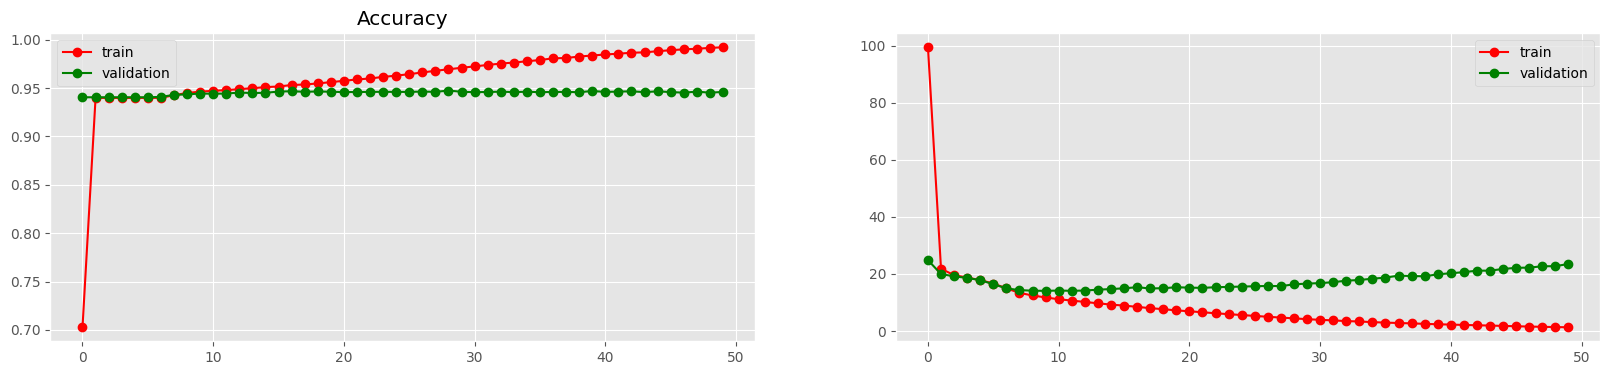

In [10]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.plot(hist["accuracy"], label="train", marker="o", c="red")
plt.plot(hist["val_val_accuracy"], label="validation", marker="o", c="green")
plt.legend()
# plt.show()
plt.subplot(1, 2, 2)
print("Loss")
plt.plot(hist["loss"], label="train", marker="o", c="red")
plt.plot(hist["val_loss_val"], label="validation", marker="o", c="green")
plt.legend()
plt.show()

In [11]:
ds = DataSaver()
train_report_df = obj.inference(model, X_train, y_train, idx2tag, train_sentences)
ds.save_report(train_report_df, "lstmcrf_ep50", "train")

valid_report_df = obj.inference(model, X_valid, y_valid, idx2tag, valid_sentences)
ds.save_report(valid_report_df, "lstmcrf_ep50", "valid")

test_report_df = obj.inference(model, X_test, y_test, idx2tag, test_sentences)
ds.save_report(test_report_df, "lstmcrf_ep50", "test")

449/449 [==============================] - 19s 42ms/step
Shape of y_pred: (14352, 52)
24/24 [==============================] - 1s 27ms/step
Shape of y_pred: (755, 52)
6611/6611 [==============================] - 307s 46ms/step
Shape of y_pred: (211527, 52)
